## Radial Basis Function (RBF)

A **radial function** is a function $\phi: [0, \infty) \rightarrow \mathbb{R}$ paired with a norm on a vector space $||\cdot||: V \rightarrow [0, \infty)$, taking the form 
$$
    \phi_{\mathbf{c}}(\mathbf{x}) = \phi(||\mathbf{x} - \mathbf{c}||)
$$
where $\mathbf{c} \in V$ is the center of this **radial kernel**. In other words, the value of the radial function depends only on the distance between the input and some fixed point. Alternatively, the center could be the origin so that $\phi_{\mathbf{0}}(\mathbf{x}) = \phi(||\mathbf{x}||)$. We usually use the $L_2$ norm as the distance metric.

A radial function and the associated radian kernels are said to be radial basis functions if, for any finite set of vectors $\{\mathbf{x}_i\}_{i=1}^n \subseteq V$, all of the following conditions are true:
- All radial kernels $\phi_{\mathbf{x}_i}(\mathbf{x})$ are linearly independent.
- All radial kernels $\phi_{\mathbf{x}_i}(\mathbf{x})$ form a basis for a **Haar Space**, which means that the interpolation matrix is non-singular:
$$
    \begin{bmatrix}
        \phi_{\mathbf{x}_1}(\mathbf{x}_1) & \phi_{\mathbf{x}_1}(\mathbf{x}_2) & \dots & \phi_{\mathbf{x}_1}(\mathbf{x}_n) \\
        \phi_{\mathbf{x}_2}(\mathbf{x}_1) & \phi_{\mathbf{x}_2}(\mathbf{x}_2) & \dots & \phi_{\mathbf{x}_2}(\mathbf{x}_n) \\
        \vdots & \vdots & \ddots & \vdots \\
        \phi_{\mathbf{x}_n}(\mathbf{x}_1) & \phi_{\mathbf{x}_n}(\mathbf{x}_2) & \dots & \phi_{\mathbf{x}_n}(\mathbf{x}_n) 
    \end{bmatrix}
$$

Commonly, the Gaussian radial basis function is used, defined as follows:
$$
    \phi_{\mathbf{x}_i}(\mathbf{x}) = \exp(-(\gamma ||\mathbf{x} - \mathbf{x}_i||)^2)
$$
where $\gamma$ is the shape parameter used to scale the input to the radial kernel. The default value for $\gamma$ is $\gamma = 1/\sqrt{2}$.

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from sklearn.datasets import load_diabetes

X, y = load_diabetes(return_X_y=True)

X.shape, y.shape

((442, 10), (442,))

### Standard Least-Squares Linear Regression

In [28]:
# prepend column of 1's to create affine transformation 
X_affine = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
X_affine.shape

(442, 11)

In [105]:
# use Moore-Penrose pseudo inverse
betas = np.linalg.pinv(X_affine) @ y.reshape(-1, 1)

# predict (reconstruct true y values)
y_pred = X_affine @ betas

# mse
np.mean((y_pred.flatten() - y)**2)

2859.6963475867506

Text(0, 0.5, 'target y')

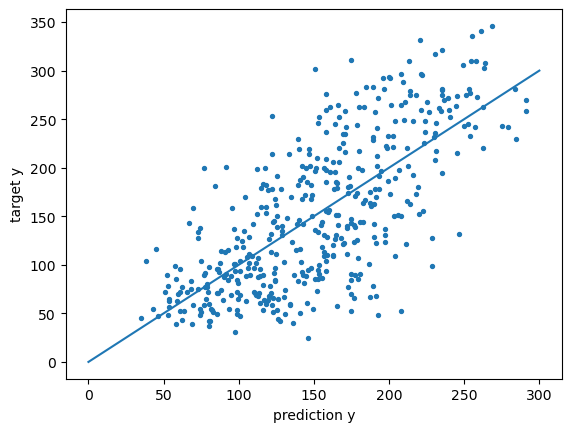

In [106]:
plt.scatter(y_pred, y, s=8)
plt.plot([0, 300], [0, 300])
plt.xlabel("prediction y")
plt.ylabel("target y")

### Radial Basis Function regression

Radial basis functions are typically used to build up function approximations of the form
$$
    f(\mathbf{x}) = \sum_{i=1}^n \beta_i \phi_{\mathbf{x}_i}(\mathbf{x}) = \left<\bm{\beta}, \bm{\phi}(\mathbf{x})\right>
$$
We can solve for the $\beta_i$ coefficients using canonical least squares. Essentially, the radial basis functions allow us to project the current data $\mathbf{x}$ into higher dimensions, which means that there will be more $\beta_i$ coefficients to estimate.  

In [103]:
def RBF(x, x_i, gamma=1/2**0.5):
    return np.exp(-(gamma * np.linalg.norm(x - x_i, axis=1, ord=2))**2)

# kernel matrix 
phi_X = RBF(X_affine.T[None, ...], X_affine[..., None])

# estimate betas
betas = np.linalg.pinv(phi_X) @ y.reshape(-1, 1)

# predict
y_pred = phi_X @ betas

# mse
np.mean((y_pred.flatten() - y)**2)

0.0007851803464587457

([24.974609375, 345.982421875], [25.0, 346.0])

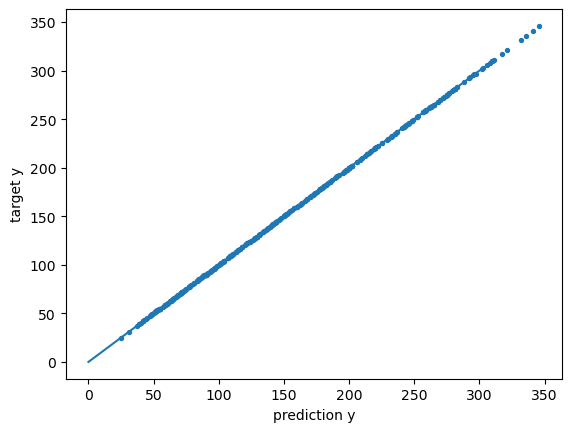

In [104]:
pred_min, pred_max = np.min(y_pred), np.max(y_pred)
true_min, true_max = np.min(y), np.max(y)

plt.scatter(y_pred, y, s=8)
# plt.plot([pred_min, pred_max], [true_min, true_max])
plt.plot([0, 300], [0, 300])
plt.xlabel("prediction y")
plt.ylabel("target y")

[pred_min, pred_max], [true_min, true_max]

#### Different $\gamma$ parameters

2859.696461799817 0.001
1543.012722515952 0.1437142857142857
693.133983491233 0.2864285714285714
127.48867894513575 0.42914285714285716
6.51159433218149 0.5718571428571428
0.003223591800189126 0.7145714285714285
4.476443674769337e-05 0.8572857142857143
3.983093872329229e-06 1.0


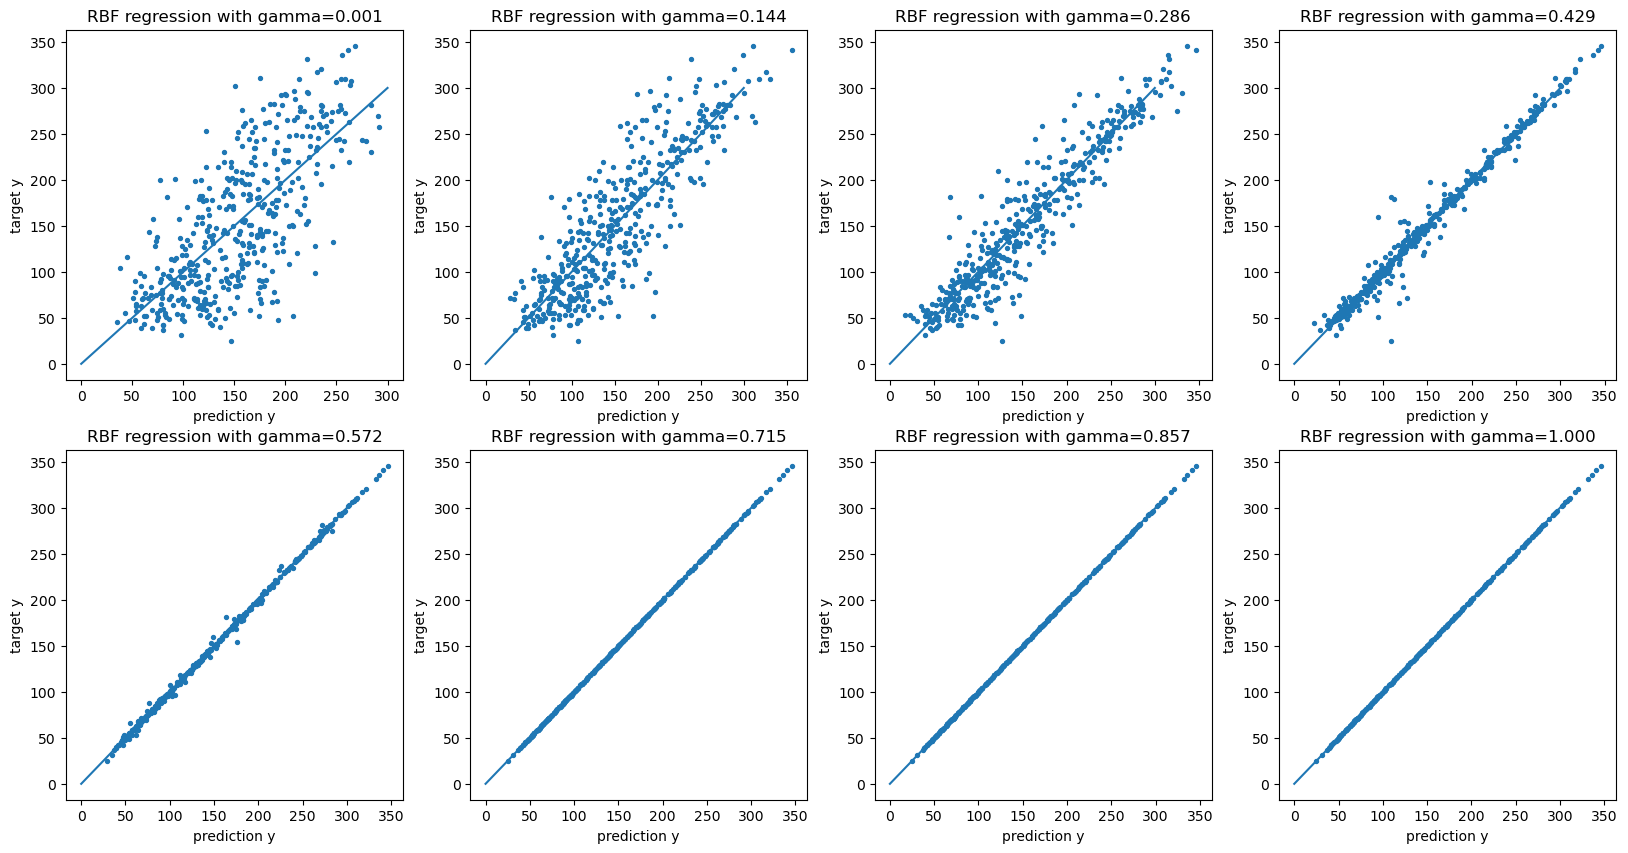

In [102]:

gammas = np.linspace(0.001, 1, 8) #* 1/2**0.5

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for ax, gamma in zip(axes.flatten(), gammas):

    # kernel matrix 
    phi_X = RBF(X_affine.T[None, ...], X_affine[..., None], gamma=gamma)

    # estimate betas
    betas = np.linalg.pinv(phi_X) @ y.reshape(-1, 1)

    # predict
    y_pred = phi_X @ betas

    # mse
    mse_loss = np.mean((y_pred.flatten() - y)**2)
    print(mse_loss, gamma)

    ax.scatter(y_pred, y, s=8)
    # plt.plot([pred_min, pred_max], [true_min, true_max])
    ax.plot([0, 300], [0, 300])
    ax.set_title(f"RBF regression with {gamma=:.3f}")
    ax.set_xlabel("prediction y")
    ax.set_ylabel("target y")

### RBF network

In [ ]:
import torch
import torch.nn as nn

def torch_RBF(x: torch.Tensor, x_i: torch.Tensor, gamma=1/2**.5):
    return torch.exp(-(gamma * torch.norm(x - x_i, dim=1, p=2))**2)

class RBF_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.LazyLinear(1)
    
    def forward(self, x: torch.Tensor):
        x = self.fc(torch_RBF(x.T[None, ...], x[..., None]))
        return torch.sigmoid(x)

rbf_mlp = RBF_MLP()
x = torch.randn(32, 10)
rbf_mlp(x).shape

torch.Size([32, 1])

((400, 2), (100, 2), (400,), (100,))

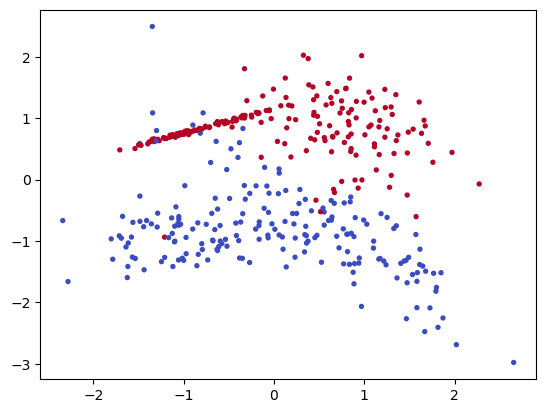

In [134]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=500,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    class_sep=1
)

# normalize so that mean is zero and unit variance
X = (X - X.mean(axis=0))/X.std(axis=0)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y)

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=8, cmap="coolwarm")

X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [143]:
X_train.shape

indices = np.random.random_integers(0, y_train.shape[0], size=32)
X_tensor = torch.tensor(X_train[indices], dtype=torch.float)
y_tensor = torch.tensor(y_train[indices], dtype=torch.float).reshape(-1, 1)

C:\Users\janba\AppData\Local\Temp\ipykernel_12772\4267010318.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 400 + 1) instead
  indices = np.random.random_integers(0, y_train.shape[0], size=32)


In [164]:
rbf_mlp = RBF_MLP()

optim = torch.optim.Adam(rbf_mlp.parameters(), lr=0.1)

bce_loss = nn.BCELoss()

n = 100

for _ in range(100):

    mean_loss = 0
    for _ in range(n):
        indices = np.random.randint(0, y_train.shape[0], size=32)
        X_tensor = torch.tensor(X_train[indices], dtype=torch.float)
        y_tensor = torch.tensor(y_train[indices], dtype=torch.float).reshape(-1, 1)
        
        y_pred = rbf_mlp(X_tensor)

        loss = bce_loss(y_pred, y_tensor)
        mean_loss += loss.item()

        optim.zero_grad()
        loss.backward()
        optim.step()
    
    print(mean_loss/n)

c:\Users\janba\anaconda3\envs\workspace_jan\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


0.7793186074495315
0.7205684992671013
0.7457586392760277
0.761886533498764
0.7303864134848118
0.7913636085391045
0.7587581092119217
0.7680074894428253
0.7516384842991829
0.7514251752197743
0.7751839169859887
0.7598689672350883
0.7489600518345833
0.7348266017436981
0.7486247324943542
0.7204354208707809
0.7959397479891777
0.7310904297232628
0.776607263982296
0.7507114532589912
0.733159807920456
0.7508501443266868
0.788882683813572
0.7790258824825287
0.728488410115242
0.7496396687626838
0.7438026830554009
0.7181066988408565
0.7337855665385723
0.7719147589802742
0.7401126855611802
0.7317198210954666
0.7901138526201248
0.7842766264081001
0.7419211921095848
0.7498562955856323
0.7562904462218285
0.7661360529065132
0.7661427143216133
0.7291253423690796
0.770448936522007
0.7656805317103863
0.7541840842366219
0.736234869658947
0.7545182982087135
0.8009712409973144
0.7410115233063698
0.6977455309033394
0.7978245177865029
0.7219029197096825
0.7499421006441116
0.7756047570705413
0.7351845696568489


In [165]:
# create cartesian product
xmin = X[:, 0].min(); xmax = X[:, 0].max()
ymin = X[:, 1].min(); ymax = X[:, 1].max()
xx, yy = np.meshgrid(
    np.linspace(xmin-.5, xmax+.5, 100),
    np.linspace(ymin-.5, ymax+.5, 100)
)
D = np.array([xx.ravel(), yy.ravel()]).T
D.shape

(10000, 2)

In [168]:
y_pred = rbf_mlp(torch.tensor(D, dtype=torch.float))

plt.scatter(X[:, 0], X[:, 1], c=y_pred, cmap='coolwarm')
plt.contourf(xx, yy, y_pred.reshape(xx.shape), cmap='coolwarm', alpha=0.4, antialiased=True)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10000x10000 and 32x1)